In [505]:
using JuMP  
using Ipopt 
using Plots
using Plots.PlotMeasures

Example#1: Spatially Hybrid OCP

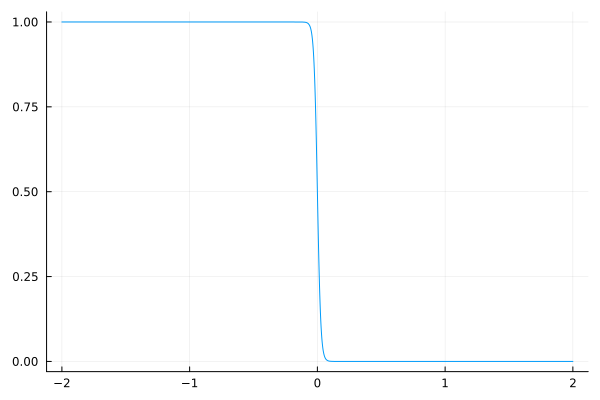

In [506]:
distance_squared(x, a) = x < a ? (a - x)^2 : 0 ;

#Moreau Yosida regularization

function MY_reg(x, k)
    return 1/(1+exp(-k*x))
end
f(x) = MY_reg(x, 75)
g(x) = 1 - f(x)
plot(g, -2, 2, legend=false)

In [508]:
mutable struct Direct
    t; x1; x2; u ; 
end

In [509]:
function example(x0; solution=[], nsteps=200, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-6)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
    set_optimizer_attribute(sys,"max_iter",500)

    N  = nsteps     # Grid size

    @variables(sys, begin
        x1[1:N+1]          
        x2[1:N+1]          
     (1/2) ≤ u[1:N+1] ≤ 3   # Control
    end)

    T   = 1.5    ;
    Δt  = T/N     ; 
    
    # Objective
    #@NLobjective(sys, Min, -b4[N+1]+(1/ϵ)*s33[N+1])
    @NLobjective(sys, Max, x1[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]     == x0[1]
        con_x20, x2[1]     == x0[2]
        con_x1f, x2[N+1]   == 2.


    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1],(g(x2[j]))*(-u[j]*x1[j])    + (f(x2[j]))*(2*x1[j]+(1/3)*x2[j]))
    @NLexpression(sys, dx2[j = 1:N+1],(g(x2[j]))*(-2*x2[j]-u[j]+3)+ (f(x2[j]))*(x2[j]+u[j]))
    

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
    end);

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    u = value.(u)[:]

    t  = (0:N) * value.(Δt)


    return Direct(t, x1, x2, u)
    
end;

In [510]:
# Resolution
x0         = [3, -2] ;
direct_sol = example(x0, nsteps=600);

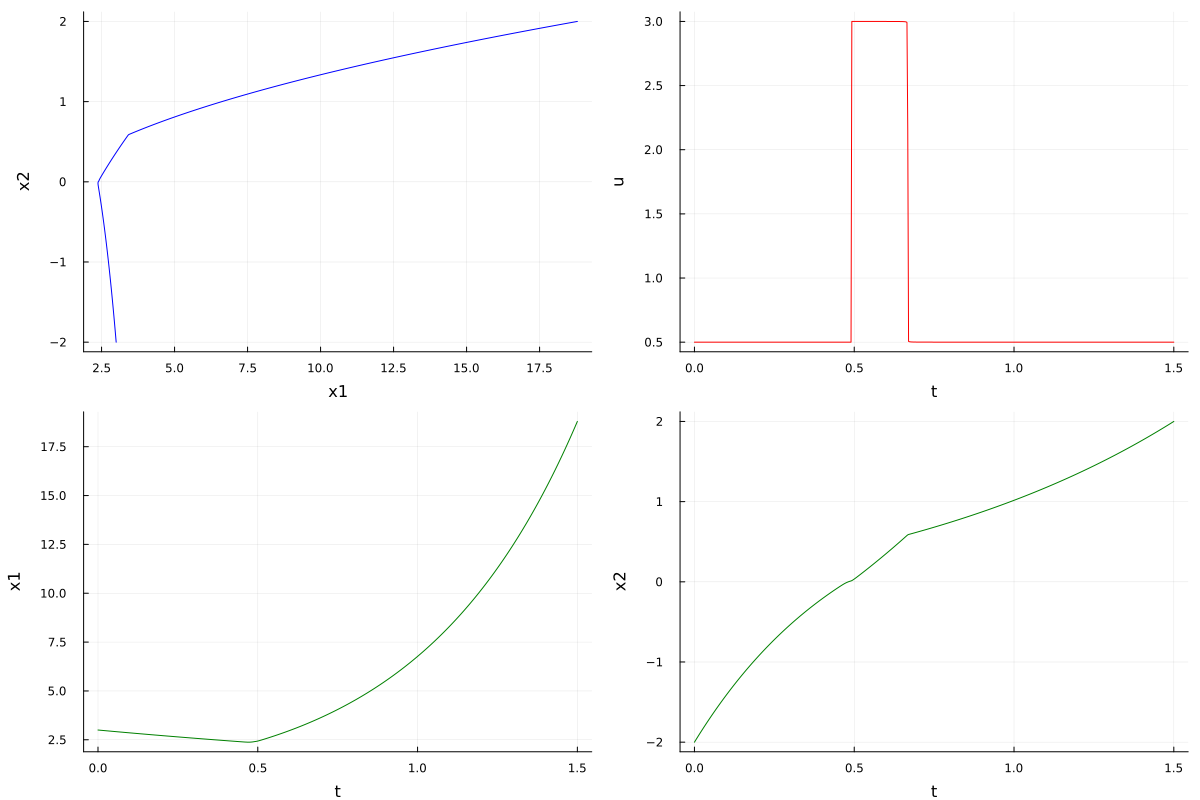

In [511]:
t  = direct_sol.t
x1 = direct_sol.x1
x2 = direct_sol.x2
u  = direct_sol.u

a  = plot(x1, x2,  xlabel = "x1", ylabel = "x2",color="blue",  legend = false)
a1  = plot(t, x1,  xlabel = "t", ylabel = "x1",color="green",  legend = false)
a2  = plot(t, x2,  xlabel = "t", ylabel = "x2", color="green",  legend = false)

b  = plot(t, u,  xlabel = "t", ylabel = "u",color="red",  legend = false)

plot(a, b,a1, a2, layout = (2,2), size=(1200,800), left_margin=5mm)


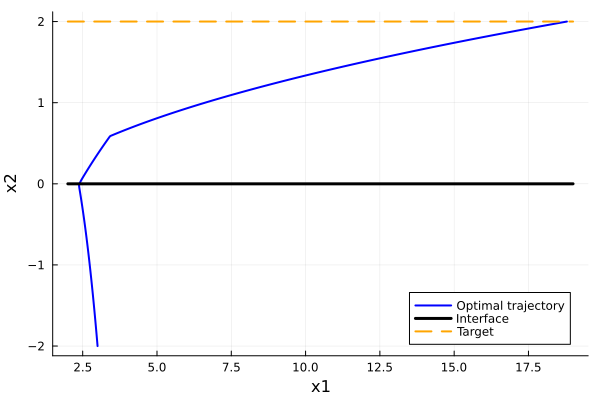

In [512]:

# Create the initial plot
plot(x1, x2, xlabel = "x1", ylabel = "x2", linecolor = "blue", linewidth = 2, label = "Optimal trajectory")

# Add a black line from (2,0) to (7,0)
plot!([2, 19], [0, 0], linecolor = "black", linewidth = 3, label = "Interface")
plot!([2, 19], [2, 2], linecolor = "orange", linewidth = 2,  linestyle = :dash, label = "Target")

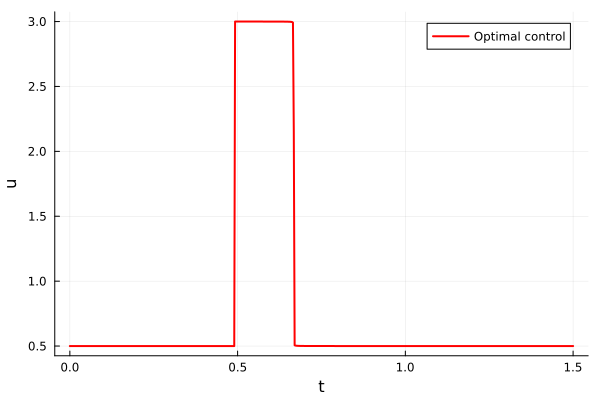

In [514]:
plot(t, u, xlabel = "t", ylabel = "u", linecolor = "red", linewidth = 2, label = "Optimal control")


Example#2: Temporally Hybrid OCP

In [516]:
mutable struct DirectSS
    t; t1;  y1; y2; z1 ; z2 ; u1 ; u2 
end

In [517]:
function example2(x0; solution=[], nsteps=200, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-6)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
    set_optimizer_attribute(sys,"max_iter",500)

    N  = nsteps     # Grid size

    @variables(sys, begin
        y1[1:N+1]          
        y2[1:N+1] 
        z1[1:N+1]          
        z2[1:N+1]          
 (1/2) ≤ u1[1:N+1] ≤ 3   # Control
 (1/2) ≤ u2[1:N+1] ≤ 3   # Control
    0. ≤ t1 ≤ 1.5
    end)

    T   = 1.5     ;
    Δt  = 1/N     ; 
    
    # Objective
    #@NLobjective(sys, Min, -b4[N+1]+(1/ϵ)*s33[N+1])
    @NLobjective(sys, Max, z1[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_y10, y1[1]     == x0[1]
        con_y20, y2[1]     == x0[2]
        con_z2f, z2[N+1]   == 2.

        con_y100, y1[N+1]  == z1[1]
        con_y200, y2[N+1]  == z2[1]
        con_y2000,  z2[1]  == 0.

        0. ≤ t1 ≤ 1.5
    end)

    # Dynamics
    @NLexpression(sys, dy1[j = 1:N+1],     t1*(-u1[j]*y1[j]))
    @NLexpression(sys, dy2[j = 1:N+1],     t1*(-2*y2[j]-u1[j]+3))

    
    @NLexpression(sys, dz1[j = 1:N+1], (T-t1)*(2*z1[j]+(1/3)*z2[j]))
    @NLexpression(sys, dz2[j = 1:N+1], (T-t1)*(z2[j]+u2[j]))

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin

        con_dy1[j=1:N], y1[j+1] == y1[j] + 0.5 * Δt * (dy1[j+1] + dy1[j])
        con_dy2[j=1:N], y2[j+1] == y2[j] + 0.5 * Δt * (dy2[j+1] + dy2[j])
        con_dz1[j=1:N], z1[j+1] == z1[j] + 0.5 * Δt * (dz1[j+1] + dz1[j])
        con_dz2[j=1:N], z2[j+1] == z2[j] + 0.5 * Δt * (dz2[j+1] + dz2[j])
    
    end);

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    y1 = value.(y1)[:]
    y2 = value.(y2)[:]
    u1 = value.(u1)[:]

    z1 = value.(z1)[:]
    z2 = value.(z2)[:]
    u2 = value.(u2)[:]

    t1 = value.(t1)

    t  = (0:N) * value.(Δt)


    return DirectSS(t, t1, y1, y2, z1, z2, u1, u2)
    
end;

In [518]:
# Resolution
x0         = [3, -2] ;
direct2 = example2(x0, nsteps=600);

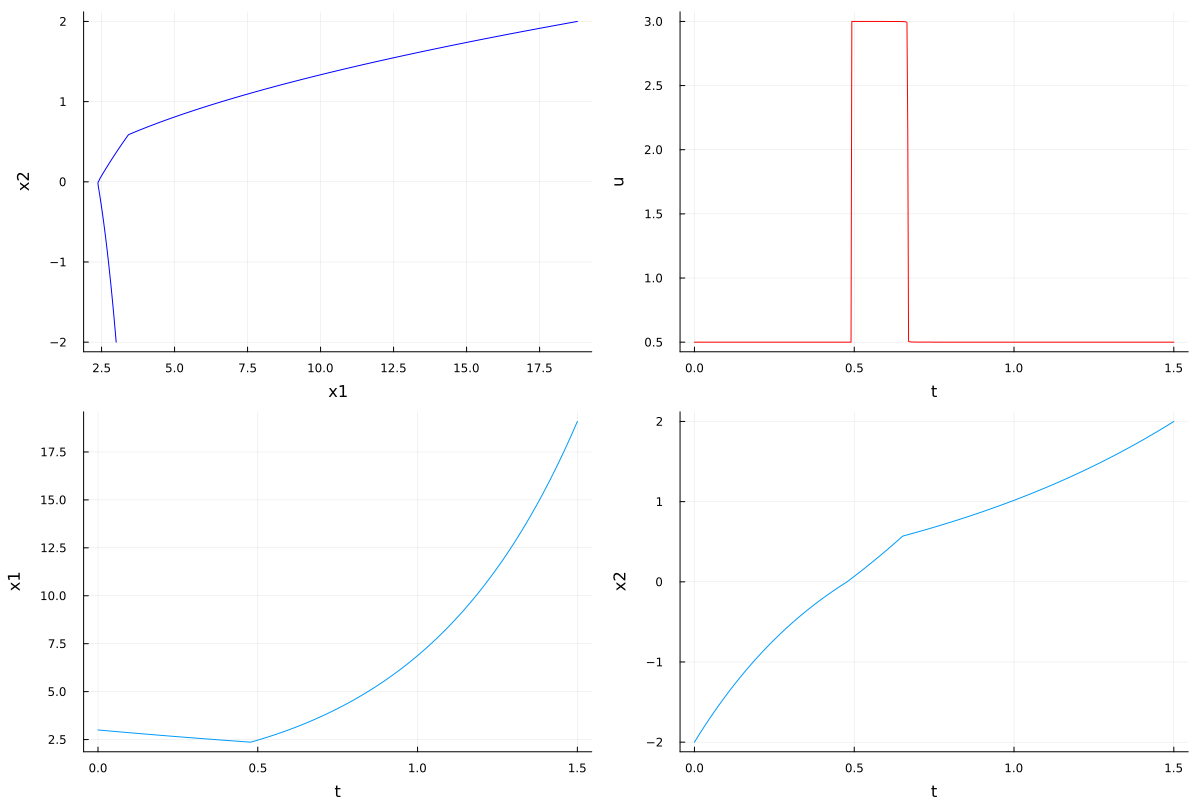

In [519]:
t  = direct2.t
t1 = direct2.t1
tX1   = t .* t1
tX2   = t1*ones(length(t)) + t .* (1.5-t1)
tt_all = vcat(tX1, tX2);
     

y1 = direct2.y1
y2 = direct2.y2
z1 = direct2.z1
z2 = direct2.z2

xx1  = vcat(y1, z1)
xx2 = vcat(y2, z2)

u1 = direct2.u1
u2 = direct2.u2
uu  = vcat(u1, u2)


aa = plot(xx1, xx2,   xlabel = "x1", ylabel = "x2",   color="blue" ,  legend = false)
bb = plot(tt_all, uu,  xlabel = "t", ylabel = "b",    color="red",    legend = false)
cc = plot(tt_all, xx1,  xlabel = "t", ylabel = "x1",  color="green",  legend = false)
dd = plot(tt_all, xx2,  xlabel = "t", ylabel = "x2",  color="green",  legend = false)


plot(a,b,c, d,  layout = (2,2), size=(1200,800), left_margin=5mm)

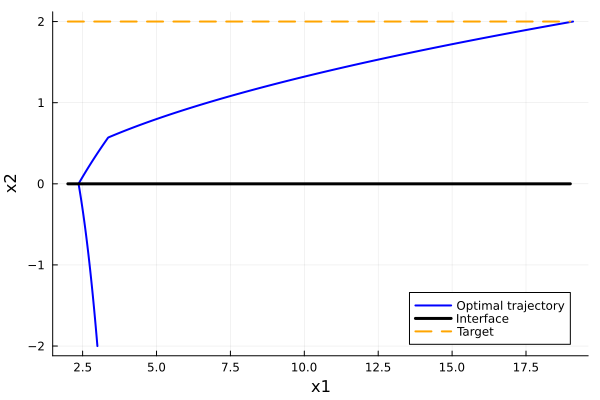

In [520]:
# Create the initial plot
plot(xx1, xx2, xlabel = "x1", ylabel = "x2", linecolor = "blue", linewidth = 2, label = "Optimal trajectory")

# Add a black line from (2,0) to (7,0)
plot!([2, 19], [0, 0], linecolor = "black", linewidth = 3, label = "Interface")
plot!([2, 19], [2, 2], linecolor = "orange", linewidth = 2,  linestyle = :dash, label = "Target")

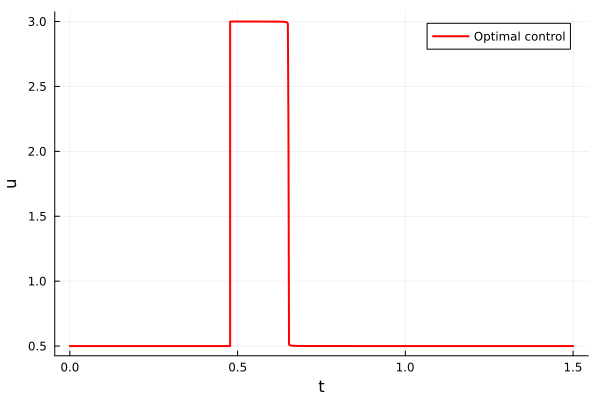

In [522]:
plot(tt_all, uu, xlabel = "t", ylabel = "u", linecolor = "red", linewidth = 2, label = "Optimal control")
